## Pairs trading on different portfolios based on Machine Learning

Statistical arbitrage is the trading strategy developed using quantitative and statistical models to generate trading signals. Pairs-trading is one of the statistical arbitrage techniques. Here, this teschnique will be investigated using ML model LSTM (Long Short-term Memory) 

### Different steps in this project

1. Selecting 20 different stocks
2. Categorizing stocks into different types (aggressive or defensive types) 
3. Identifying pairs with co-integration test 
4. Constructing Portfolio
5. Forecasting stock prices using ML algorithm, LSTM 
6. Calculating Trading Profits 

### Why LSTM?

Among different types of models, deep learning models contain neural networks. Neural networks are capable of providing decent approximation to almost all non-linear functions. Due to the non-linearity of time series data, it is better to use neural networks to predict stock prices, rather than using regular linear frameworks.

Merits of using Neural networks
* Neural networks are designed to detect non-linearities that exist within the data
* Neural networks are scalable with reduced computational load, because, training or updating doesnot require retraining the entire model from scratch when new data is added. 

### Neural Networks

Neural Networks composed of input layer, several hiddien layers and then output layer. Input layer holds the input values, hidden layers process these input values through non-linear functions and the final output is provided at the output layer. Artificial Neurons are the building block of these different layers.

## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  
import yfinance as yf 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 

import warnings
warnings.filterwarnings('ignore')

#### Selecting 20 different stocks

In [2]:
tickers = ['AMD','AAPL','CSCO','INTC','ORCL','MSFT','GOOGL','DIS','CEA','ERIC',
           'HPQ','WMT','PCG','JNJ','NEE','AEP','COKE','PEP','MCD','MRK']

start_date = '2008-01-01'
end_date = '2018-01-01'  

In [3]:
data_frames = {} 
fail = []
for tick in tickers:  
    df = pd.DataFrame()
    df = yf.download(tick,start=start_date,end=end_date)
    if len(df)==0:
        fail.append(tick) 
        continue 
    else:
        df.rename(columns={'Open':f'{tick}_Open','High':f'{tick}_High','Low':f'{tick}_Low','Close':f'{tick}_Close',
                       'Volume':f'{tick}_Volume','Adj Close':f'{tick}_Adj Close'},inplace=True) 
        data_frames[f'df_{tick}'] = df 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['CEA']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*****

In [4]:
print(f'Total tickers considered : ',len(tickers)) 
print(f'Data download failed for tickers : ',fail) 
print(f'Total tickers available : ',len(data_frames))   

Total tickers considered :  20
Data download failed for tickers :  ['CEA']
Total tickers available :  19


In [5]:
data_frames['df_AMD'].shape 

(2518, 6)

In [6]:
data_frames['df_AAPL'].head() 

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,
2008-01-02,7.116786,7.152143,6.876786,6.958571,5.883142,1079178800
2008-01-03,6.978929,7.049643,6.881786,6.961786,5.885861,842066400
2008-01-04,6.837500,6.892857,6.388929,6.430357,5.436563,1455832000
2008-01-07,6.473214,6.557143,6.079643,6.344286,5.363796,2072193200
2008-01-08,6.433571,6.516429,6.100000,6.116071,5.170848,1523816000


#### Scaling the values in each dataframe and storing the corresponding arrays and data frames in dictionary format 

In [7]:
scaled_data = {}
scaled_df = {} 
for tick,df in data_frames.items():
    original_index = df.index 
    scaled_data[f'{tick}'] = sc.fit_transform(df) 
    scaled_df[f'{tick}'] = pd.DataFrame(data=scaled_data[f'{tick}'], columns=df.columns)
    scaled_df[f'{tick}'].index = original_index  

#### Finding the standard deviation of each column in each dataframe and storing it in a dictionary

In [8]:
standard_dev = {}
for tick, df in scaled_df.items():
    standard_dev[f'{tick}'] = df.std() 

### Calculating $\beta$-coefficient

Beta measures the volatility, or systematic risk, of a stock in relation to the overall market. So, here we have to take S&P500 as benchmark.

In [9]:
df_bench_close = yf.download('^GSPC',start=start_date,end=end_date)['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed


In [10]:
stock_data_close = {}

for tick, df in data_frames.items():    
    ticker = tick.split('_')[1] 
    stock_data_close[ticker] = df[f'{ticker}_Adj Close']  

In [11]:
benchmark_returns = df_bench_close.pct_change().dropna()
variance = benchmark_returns.var() 

In [12]:
stock_returns = {}
stock_cov = {} 
beta = {}

for tick in stock_data_close:
    stock_returns[tick] = stock_data_close[tick].pct_change().dropna()  # Calculating daily returns
    stock_cov[tick] = stock_returns[tick].cov(benchmark_returns)  # Calculating covariance
    beta[tick] = stock_cov[tick]/variance   # Calculating beta-coefficient 

#### $\beta$-coefficient for respective tickers

In [13]:
sorted_beta = sorted(beta.items(), key=lambda x: x[1], reverse=True)
beta_df = pd.DataFrame(sorted_beta, columns=[['Ticker','Beta values']])
beta_df 

,Ticker,Beta values
0,AMD,1.429605
1,ERIC,1.242362
2,DIS,1.062176
3,CSCO,1.046079
4,INTC,1.023709
5,ORCL,0.993716
6,HPQ,0.972210
7,MSFT,0.956503
8,AAPL,0.948586
9,GOOGL,0.936107


Value of $\beta$ is always +ve. It is either above or below 1. 

* If $\beta<1 \implies$ variability of this asset's return rate is lower than market portfolio
* If $\beta>1 \implies$ variability of this asset's return rate is higher than market portfolio

### Classifying stocks as Aggressive and Defensive

Categorizing stocks as aggressive and defensive is based on their beta value

* Aggressive stocks : Stocks facing higher volatility in revenue, leading to higher stock returns and sensitivity to the market index. High-tech stocks are regarded as aggressive. Also, numerically, if $\beta>1$, it is referred to as aggressive stocks.

* Defensive stocks : These kind of stocks can be found under daily-necessity sectors, sucha as public utilities, pharmaceutical firms, airline and tourism industries etc... If $\beta<1$, it is referred to as defensive stocks.

In [14]:
aggressive = []
defensive = []

for tick, value in beta.items():
    if value>1.0:
        aggressive.append(tick)
    else:
        defensive.append(tick)     

In [15]:
aggressive 

['AMD', 'CSCO', 'INTC', 'DIS', 'ERIC']

In [16]:
defensive 

['AAPL',
 'ORCL',
 'MSFT',
 'GOOGL',
 'HPQ',
 'WMT',
 'PCG',
 'JNJ',
 'NEE',
 'AEP',
 'COKE',
 'PEP',
 'MCD',
 'MRK']

### Identifying pairs with cointegration test

1. Augmented Dickey-Fuller unit root test : Used to test the cointegration relationship between two objects after conducting stationary test
2. Augmented Engle-Granger two step cointegration test

#### Stationarity and Augmented Dickey-Fuller test (ADF)

Stationarity in a time series analysis implies that the statistical properties of a time series such as mean, variance and auto-correlation are constant over time. ADF is a commonly used statistical test to check for stationarity. The null hypothesis of ADF test is that the time series has a unit root, that is it is non-stationary whereas alternative hypothesis is that the time series is stationary.

* p-value $<0.05$ gives that the null hypothesis can be rejected and the series is stationary
* p-value $>0.05$ gives that the series is non-stationary  

In [17]:
from statsmodels.tsa.stattools import adfuller 

#### Function to perform adf test

In [18]:
def adf_test(series, tick):
    result = adfuller(series)
    print('-'*20,tick,'-'*20)
    print()  
    print(f'ADF statistic for {tick} : {result[0]}')
    print(f'p-value for {tick} : {result[1]}') 
    for key, values in result[4].items():
        print(f'Critical values {key} for {tick} : {values}') 
    print()

In [19]:
for tick, df in stock_data_close.items():
    adf_test(df,tick) 

-------------------- AMD --------------------

ADF statistic for AMD : -1.4140006569239492
p-value for AMD : 0.5755459280644902
Critical values 1% for AMD : -3.4329610922579095
Critical values 5% for AMD : -2.8626935681060375
Critical values 10% for AMD : -2.567384088736619

-------------------- AAPL --------------------

ADF statistic for AAPL : 0.8142214801584464
p-value for AAPL : 0.9918622954993679
Critical values 1% for AAPL : -3.4329507078222634
Critical values 5% for AAPL : -2.8626889823128554
Critical values 10% for AAPL : -2.567381647203466

-------------------- CSCO --------------------

ADF statistic for CSCO : 0.07152663895709986
p-value for CSCO : 0.9640624502072714
Critical values 1% for CSCO : -3.4329517425474014
Critical values 5% for CSCO : -2.862689439250822
Critical values 10% for CSCO : -2.5673818904827863

-------------------- INTC --------------------

ADF statistic for INTC : 0.5463574695489667
p-value for INTC : 0.9862160295441531
Critical values 1% for INTC : -

#### Creating a data frame with Adj Close values

In [20]:
def dataframeClose(tickers):
    df_close = pd.DataFrame()

    for tick in tickers:
        df = yf.download(tick, start=start_date, end=end_date)
        if len(df)==0:
           continue
        else:
          df_close[tick]=df['Adj Close'] 

    return df_close       

In [21]:
df_aggClose = dataframeClose(aggressive) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [22]:
df_defClose = dataframeClose(defensive) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [23]:
def p_valueFn(series):
    result = adfuller(series)
    return result[1] 

In [24]:
import itertools 

In [25]:
def pairsList(df_close):
    pairs_l = []
    pairs_g = []

    for pair in itertools.combinations(df_close.columns,2):
        spread  = df_close[pair[0]] - df_close[pair[1]]
        p_value = p_valueFn(spread.dropna()) 
        if p_value<0.05:
            pairs_l.append((pair[0],pair[1],p_value))
        else:
            pairs_g.append((pair[0],pair[1],p_value)) 
    return pairs_l, pairs_g            

In [26]:
pairs_aggL, pairs_aggG = pairsList(df_aggClose)
pairs_defL, pairs_defG = pairsList(df_defClose) 

In [27]:
pairs_aggG 

[('AMD', 'CSCO', 0.7575659215233912),
 ('AMD', 'INTC', 0.8713820100753229),
 ('AMD', 'DIS', 0.9082337937762573),
 ('AMD', 'ERIC', 0.6689591651589208),
 ('CSCO', 'INTC', 0.3109239904297719),
 ('CSCO', 'DIS', 0.852395978664318),
 ('CSCO', 'ERIC', 0.9925576095502731),
 ('INTC', 'DIS', 0.8110223390449144),
 ('INTC', 'ERIC', 0.9957810170603515),
 ('DIS', 'ERIC', 0.9438495633903984)]

In [28]:
pairs_aggL 

[]

In [29]:
pairs_defG 

[('AAPL', 'ORCL', 0.08049347533011147),
 ('AAPL', 'MSFT', 0.9903229810229084),
 ('AAPL', 'GOOGL', 0.2994456626823279),
 ('AAPL', 'HPQ', 0.8977018476388652),
 ('AAPL', 'WMT', 0.8525848865855867),
 ('AAPL', 'PCG', 0.5141507219807969),
 ('AAPL', 'JNJ', 0.9516735072841721),
 ('AAPL', 'NEE', 0.31754920238070017),
 ('AAPL', 'AEP', 0.19167950342579565),
 ('AAPL', 'COKE', 0.9638505957921624),
 ('AAPL', 'PEP', 0.7898448717878486),
 ('AAPL', 'MCD', 0.9948420318380783),
 ('AAPL', 'MRK', 0.055834520436543356),
 ('ORCL', 'MSFT', 0.9954924317364781),
 ('ORCL', 'GOOGL', 0.6968380931126179),
 ('ORCL', 'HPQ', 0.5786387916324152),
 ('ORCL', 'WMT', 0.2468988613909564),
 ('ORCL', 'PCG', 0.3594193703370833),
 ('ORCL', 'JNJ', 0.9876642317552701),
 ('ORCL', 'AEP', 0.5090698940165516),
 ('ORCL', 'COKE', 0.9763369756807769),
 ('ORCL', 'PEP', 0.9345251540154578),
 ('ORCL', 'MCD', 0.9985675144389304),
 ('MSFT', 'GOOGL', 0.9677538637650864),
 ('MSFT', 'HPQ', 0.9990245846603626),
 ('MSFT', 'WMT', 0.997502279932051

In [30]:
pairs_defL

[('ORCL', 'NEE', 0.028479414715996455),
 ('ORCL', 'MRK', 0.021433379829797185),
 ('GOOGL', 'AEP', 0.0014554392566606135)]

In [31]:
df_defClose.head() 

,AAPL,ORCL,MSFT,GOOGL,HPQ,WMT,PCG,JNJ,NEE,AEP,COKE,PEP,MCD,MRK
Date,,,,,,,,,,,,,,
2008-01-02,5.883142,18.300970,25.535210,17.127239,15.035043,10.940402,29.559355,40.545521,10.177977,23.933067,48.633259,46.554634,36.491596,30.541336
2008-01-03,5.885861,18.805481,25.643961,17.130739,15.035043,10.819095,29.655035,40.557816,10.273084,24.005430,47.375221,46.857632,36.384834,30.514708
2008-01-04,5.436563,17.926640,24.926191,16.422592,14.193203,10.665140,29.627703,40.502460,10.556870,23.927895,46.183395,46.715401,35.832104,30.264502
2008-01-07,5.363796,18.105673,25.092937,16.228872,13.732916,10.861087,30.119789,41.129929,11.049277,24.625717,45.595753,47.809856,36.447647,30.834126
2008-01-08,5.170848,17.210564,24.251915,15.789686,13.078826,10.723457,29.935249,41.179138,10.975651,24.610220,45.446781,48.193245,35.850960,31.760427


In [32]:
import statsmodels.api as sm 

In [33]:
coint_result = sm.tsa.stattools.coint(df_defClose['JNJ'], df_defClose['NEE'])

# Print the results
coint_t, p_value, critical_values = coint_result
print(f'Cointegration Test Statistic: {coint_t}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}') 

Cointegration Test Statistic: -5.060282981569368
p-value: 0.0001273625161345325
Critical Values: [-3.90079646 -3.33855861 -3.04613545]


In [34]:
coint_result = sm.tsa.stattools.coint(df_defClose['NEE'], df_defClose['JNJ'])

# Print the results
coint_t, p_value, critical_values = coint_result
print(f'Cointegration Test Statistic: {coint_t}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}') 

Cointegration Test Statistic: -5.001555222212537
p-value: 0.00016356198908227388
Critical Values: [-3.90079646 -3.33855861 -3.04613545]


### Prediction using LSTM

In [35]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import warnings
warnings.filterwarnings('ignore')  

### Plotting daily adjusted close prices of JNJ 

In [36]:
start_pred_date = '2016-01-01'
x_test = data_frames['df_JNJ'] 
x_test = x_test[x_test.index>=start_pred_date]  

In [37]:
x_train = data_frames['df_JNJ'] 
x_train = x_train[x_train.index<start_pred_date] 
x_train.head() 

,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume
Date,,,,,,
2008-01-02,66.559998,67.000000,65.720001,65.910004,40.545521,11970500
2008-01-03,65.750000,66.400002,65.360001,65.930000,40.557816,9277600
2008-01-04,65.720001,66.400002,65.720001,65.839996,40.502460,12714800
2008-01-07,65.760002,67.209999,65.750000,66.860001,41.129929,12352700
2008-01-08,67.050003,67.750000,66.599998,66.940002,41.179138,13478500


In [38]:
x_test.head() 

,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume
Date,,,,,,
2016-01-04,101.709999,101.809998,99.449997,100.480003,79.735909,12722800
2016-01-05,100.580002,101.440002,100.570000,100.900002,80.069221,6467200
2016-01-06,99.820000,100.970001,99.599998,100.389999,79.664497,7733800
2016-01-07,99.309998,100.089996,98.879997,99.220001,78.736046,9433100
2016-01-08,99.879997,99.940002,97.849998,98.160004,77.894897,9766700


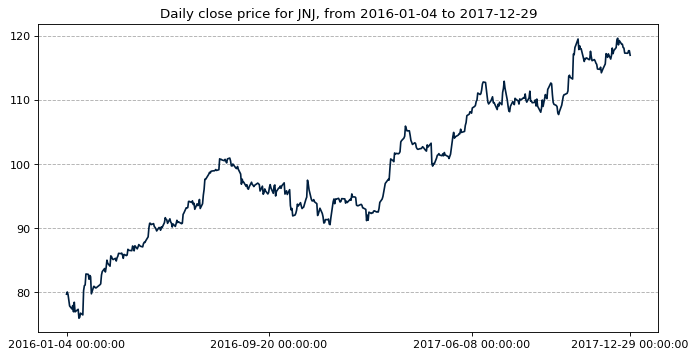

In [39]:
fig = figure(figsize=(10,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 
plt.plot(x_test.index, x_test['JNJ_Adj Close'], color="#001f3f")

xticks = (x_test.index[i] if ((i%180==0) or i==len(x_test.index)-1) else None for i in range(len(x_test.index))) 
 
display_date_range = "from "+str(x_test.index.min().date())+" to "+str(x_test.index.max().date())


xlticks = list(xticks)
x = np.arange(0,len(xlticks)) 
plt.xticks(ticks=xlticks, labels=[date for date in xlticks], ha='center')
# plt.xticks(x, xlticks, rotation='vertical') 
plt.title("Daily close price for JNJ"+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()   

In [40]:
x_train = scaled_df['df_JNJ']['JNJ_Adj Close']  

In [41]:
scaled_close_price = x_train.values  # Used for prediction using LSTM
scaled_close_price 

array([-0.9374948 , -0.93697501, -0.93931526, ...,  2.32362099,
        2.32326715,  2.29353466])

In [42]:
scaled_close_price.shape[0] 

2518

In [43]:
window_size = 20
def prepare_data_x(x, window_size):
    n_row = x.shape[0]-window_size+1 
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1] 

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output 

data_x, data_x_unseen = prepare_data_x(scaled_close_price, window_size=window_size) 
data_y = prepare_data_y(scaled_close_price, window_size=window_size) 

In [44]:
print('Shape of data_x : ',data_x.shape)
print('Shape of data_x_unseen : ',data_x_unseen.shape)
print('Shape of data_y : ',data_y.shape) 

Shape of data_x :  (2498, 20)
Shape of data_x_unseen :  (20,)
Shape of data_y :  (2498,)


In [45]:
split_index = int(data_y.shape[0]*0.80)
data_x_train = data_x[:split_index] # Each array contains a list of 20 elements 
data_x_val = data_x[split_index:] 
data_y_train = data_y[:split_index] 
data_y_val = data_y[split_index:]   # This value is used for validation against predicted values 

In [46]:
print('Arrays in data_x_train : ',len(data_x_train))
print('Arrays in data_x_val : ',len(data_x_val))
print('Arrays in data_y_train : ',len(data_y_train))
print('Arrays in data_y_val : ',len(data_y_val))  

Arrays in data_x_train :  1998
Arrays in data_x_val :  500
Arrays in data_y_train :  1998
Arrays in data_y_val :  500


### Creating Data frames 

In [47]:
x_train_df = pd.DataFrame() 
x_train_df['Dates'] = x_train.index 
x_train_df['Values'] = x_train.values  
x_train_df.head() 

,Dates,Values
0,2008-01-02,-0.937495
1,2008-01-03,-0.936975
2,2008-01-04,-0.939315
3,2008-01-07,-0.912788
4,2008-01-08,-0.910707


In [48]:
# Beginning indices of data_y_val in x_train_df 

indices = x_train_df.loc[x_train_df['Values']==data_y_val[0],'Dates']
indices  

2018   2016-01-07
Name: Dates, dtype: datetime64[ns]

In [49]:
datay_val = pd.DataFrame()
datay_train = pd.DataFrame()
datay_val = x_train_df[2018:]
datay_train = x_train_df[:2018]   

In [51]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x,2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32) 

    def __len__(self):
        return len(self.x) 

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx]) 

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val) 

print("Train data shape : ",dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape : ",dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=64, shuffle=True) 

Train data shape :  (1998, 20, 1) (1998,)
Validation data shape :  (500, 20, 1) (500,)


In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__() 
        self.hidden_layer_size = hidden_layer_size 
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)
    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]  

In [53]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to('cpu')
        y = y.to('cpu')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=64, shuffle=True)

model = LSTMModel(input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cpu') 

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

for epoch in range(100):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 100, loss_train, loss_val, lr_train)) 

Epoch[1/100] | loss train:0.034049, test:0.074112 | lr:0.010000
Epoch[2/100] | loss train:0.003849, test:0.062709 | lr:0.010000
Epoch[3/100] | loss train:0.002819, test:0.044506 | lr:0.010000
Epoch[4/100] | loss train:0.002776, test:0.045559 | lr:0.010000
Epoch[5/100] | loss train:0.003075, test:0.036159 | lr:0.010000
Epoch[6/100] | loss train:0.002061, test:0.034130 | lr:0.010000
Epoch[7/100] | loss train:0.002581, test:0.037076 | lr:0.010000
Epoch[8/100] | loss train:0.001802, test:0.022666 | lr:0.010000
Epoch[9/100] | loss train:0.002714, test:0.025687 | lr:0.010000
Epoch[10/100] | loss train:0.001977, test:0.037143 | lr:0.010000
Epoch[11/100] | loss train:0.002512, test:0.024093 | lr:0.010000
Epoch[12/100] | loss train:0.001892, test:0.033974 | lr:0.010000
Epoch[13/100] | loss train:0.001940, test:0.034595 | lr:0.010000
Epoch[14/100] | loss train:0.001805, test:0.022022 | lr:0.010000
Epoch[15/100] | loss train:0.001871, test:0.035781 | lr:0.010000
Epoch[16/100] | loss train:0.00176

### Model Evaluation

In [54]:
class Normalizer():
    def __init__(self):
        self.mean = None 
        self.std = None 

    def fit_transform(self,x):
        self.mean = np.mean(x, axis=(0), keepdims=True) 
        self.std = np.std(x, axis=(0), keepdims=True) 
        normalized_x = (x-self.mean)/self.std 
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.std)+self.mean 
    
scaler = Normalizer() 

In [55]:
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=64, shuffle=False)

model.eval() 

LSTMModel(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)

In [56]:
# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to('cpu') 
    out = model(x) 
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out)) 

In [57]:
# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to('cpu') 
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out)) 

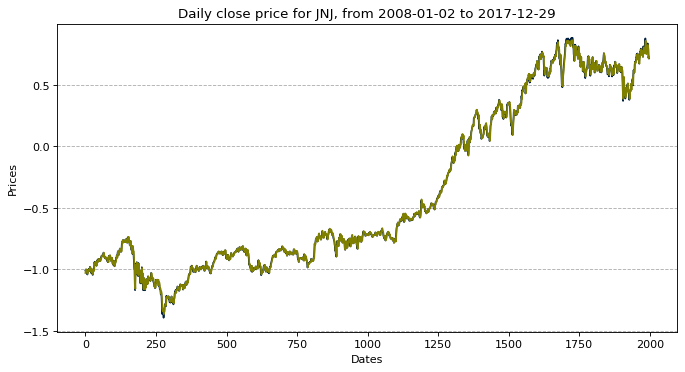

In [58]:
fig = figure(figsize=(10,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 

plt.plot(data_y_train, label='Actual Train Data', color="#001f3f")
plt.plot(predicted_train, label='Predicted Train Data', color="olive") 

 
display_date_range = "from "+str(x_train.index.min().date())+" to "+str(x_train.index.max().date())

plt.xlabel('Dates') 
plt.ylabel('Prices') 
plt.title("Daily close price for JNJ"+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()   

In [59]:
x_test = x_test[:-3] 

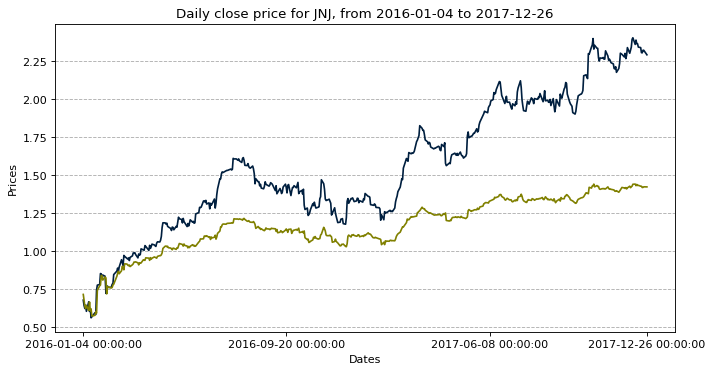

In [60]:
fig = figure(figsize=(10,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 

plt.plot(x_test.index, data_y_val, label='Actual Test Data', color="#001f3f")
plt.plot(x_test.index, predicted_val, label='Predicted Test Data', color="olive") 

xticks = (x_test.index[i] if ((i%180==0) or i==len(x_test.index)-1) else None for i in range(len(x_test.index))) 
 
display_date_range = "from "+str(x_test.index.min().date())+" to "+str(x_test.index.max().date())


xlticks = list(xticks)
x = np.arange(0,len(xlticks)) 
plt.xticks(ticks=xlticks, labels=[date for date in xlticks], ha='center')
 
plt.xlabel('Dates') 
plt.ylabel('Prices') 
plt.title("Daily close price for JNJ"+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()   

## JNJ-NEE 

In [61]:
df_jnj_nee = pd.DataFrame() 
df_jnj_nee['JNJ_Close'] = data_frames['df_JNJ']['JNJ_Adj Close']
df_jnj_nee['NEE_Close'] = data_frames['df_NEE']['NEE_Adj Close'] 
df_jnj_nee['JNJ_Returns'] = df_jnj_nee['JNJ_Close'].pct_change()
df_jnj_nee['NEE_Returns'] = df_jnj_nee['NEE_Close'].pct_change()
df_jnj_nee['Price_Spread'] = df_jnj_nee['JNJ_Close'] - df_jnj_nee['NEE_Close']
df_jnj_nee.dropna(inplace=True) 
df_jnj_nee.head() 

,JNJ_Close,NEE_Close,JNJ_Returns,NEE_Returns,Price_Spread
Date,,,,,
2008-01-03,40.557816,10.273084,0.000303,0.009344,30.284732
2008-01-04,40.502460,10.556870,-0.001365,0.027624,29.945591
2008-01-07,41.129929,11.049277,0.015492,0.046643,30.080651
2008-01-08,41.179138,10.975651,0.001196,-0.006663,30.203487
2008-01-09,41.708172,10.961845,0.012847,-0.001258,30.746326


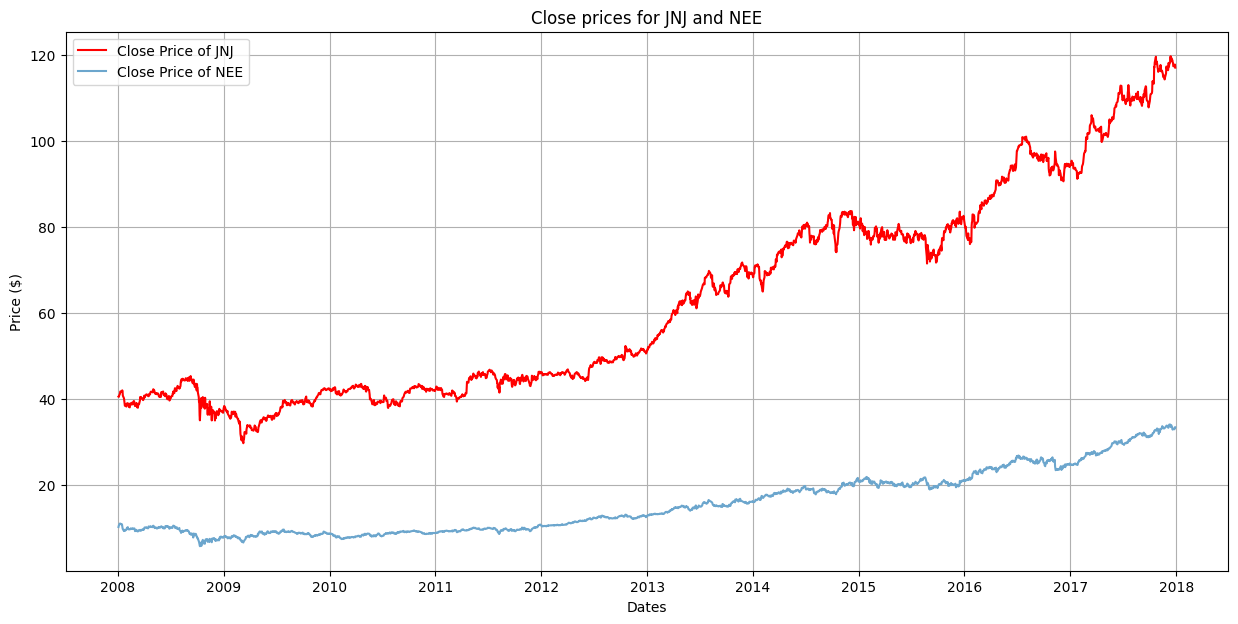

In [62]:
plt.figure(figsize=(15, 7))
plt.plot(df_jnj_nee['JNJ_Close'], lw=1.5, label='Close Price of JNJ',color='red')
plt.plot(df_jnj_nee['NEE_Close'], lw=1.5, label='Close Price of NEE',color='#6CA6CD')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price ($)')
plt.title('Close prices for JNJ and NEE')
plt.grid(True);
plt.show() 

In [63]:
x_test_spread = df_jnj_nee[df_jnj_nee.index>=start_pred_date] 
x_train_spread = df_jnj_nee[df_jnj_nee.index<start_pred_date] 

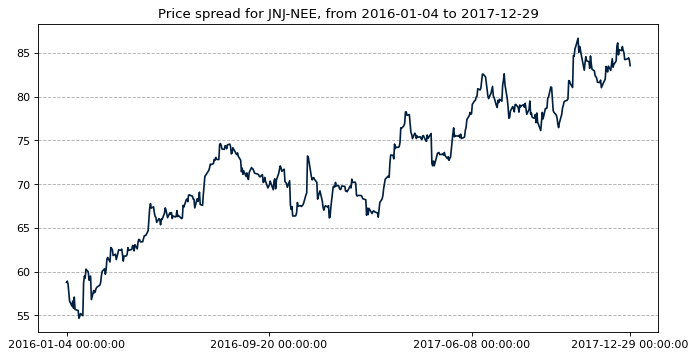

In [64]:
fig = figure(figsize=(10,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 
plt.plot(x_test_spread.index, x_test_spread['Price_Spread'], color="#001f3f")

xticks = (x_test_spread.index[i] if ((i%180==0) or i==len(x_test_spread.index)-1) else None for i in range(len(x_test_spread.index))) 
 
display_date_range = "from "+str(x_test_spread.index.min().date())+" to "+str(x_test_spread.index.max().date())


xlticks = list(xticks)
x = np.arange(0,len(xlticks)) 
plt.xticks(ticks=xlticks, labels=[date for date in xlticks], ha='center')
# plt.xticks(x, xlticks, rotation='vertical') 
plt.title("Price spread for JNJ-NEE"+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()   

In [65]:
# train = pd.DataFrame()
# train['JNJ'] = df_jnj_nee['JNJ_Close']
# train['NEE'] = df_jnj_nee['NEE_Close']

In [71]:
filtered_df = df_jnj_nee[df_jnj_nee.index>=start_pred_date] 
train = pd.DataFrame()
train['JNJ'] = filtered_df['JNJ_Close']
train['NEE'] = filtered_df['NEE_Close'] 

In [66]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller 

In [73]:
model = sm.OLS(train.JNJ,train.NEE).fit()

print('Hedge Ratio : ',model.params[0]) 

Hedge Ratio :  3.6491634299263667


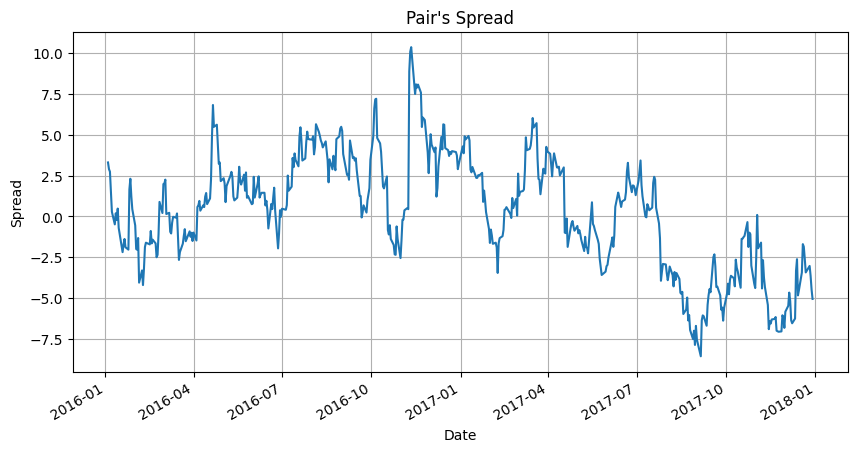

In [107]:
spread = train.JNJ - model.params[0]*train.NEE 

plot = spread.plot(figsize=(10,5), title="Pair's Spread") 
plot.set_ylabel('Spread') 
plot.grid(True);

def zscore(series):
    return (series-series.mean())/np.std(series) 

test = pd.DataFrame()
test['JNJ'] = df_jnj_nee['JNJ_Close']
test['NEE'] = df_jnj_nee['NEE_Close'] 

In [108]:
test['spread'] = test.JNJ - model.params[0]*test.NEE
test.head()  

,JNJ,NEE,spread
Date,,,
2008-01-03,40.557816,10.273084,3.069654
2008-01-04,40.502460,10.556870,1.978718
2008-01-07,41.129929,11.049277,0.809310
2008-01-08,41.179138,10.975651,1.127195
2008-01-09,41.708172,10.961845,1.706606


In [109]:
def scaling(df):
    original_index = df.index 
    scaled_data = sc.fit_transform(df) 
    scaled_df = pd.DataFrame(data=scaled_data, columns=df.columns)
    scaled_df.index = original_index   
    return scaled_data, scaled_df 

In [110]:
test_scale_data, test_scale_df =  scaling(test)   

In [111]:
test_scale_df  

,JNJ,NEE,spread
Date,,,
2008-01-03,-0.937325,-0.741555,-0.622249
2008-01-04,-0.939665,-0.702108,-0.873324
2008-01-07,-0.913138,-0.633663,-1.142459
2008-01-08,-0.911058,-0.643897,-1.069299
2008-01-09,-0.888692,-0.645816,-0.935949
...,...,...,...
2017-12-22,2.307266,2.429419,-2.117959
2017-12-26,2.306205,2.413351,-2.026654
2017-12-27,2.323193,2.451739,-2.166112


In [112]:
pair_data = test_scale_df['spread'].values 
pair_data  

array([-0.62224894, -0.87332382, -1.14245885, ..., -2.16611223,
       -2.35862898, -2.49171613])

In [113]:
pair_x, pair_x_unseen = prepare_data_x(pair_data, window_size=window_size) 
pair_y = prepare_data_y(pair_data, window_size=window_size) 

In [115]:
print('Shape of pair_x : ',pair_x.shape)
print('Shape of pair_x_unseen : ',pair_x_unseen.shape)
print('Shape of pair_y : ',pair_y.shape) 

Shape of pair_x :  (2497, 20)
Shape of pair_x_unseen :  (20,)
Shape of pair_y :  (2497,)


In [116]:
split_index = int(pair_y.shape[0]*0.80)
pair_x_train = pair_x[:split_index] # Each array contains a list of 20 elements 
pair_x_val = pair_x[split_index:] 
pair_y_train = pair_y[:split_index] 
pair_y_val = pair_y[split_index:]   # This value is used for validation against predicted values 

In [118]:
print('Length of pair_x_train : ',len(pair_x_train))
print('Length of pair_x_val : ',len(pair_x_val))
print('Length of pair_y_train : ',len(pair_y_train)) 
print('Length of pair_y_val : ',len(pair_y_val)) 

Length of pair_x_train :  1997
Length of pair_x_val :  500
Length of pair_y_train :  1997
Length of pair_y_val :  500


In [119]:
dataset_train = TimeSeriesDataset(pair_x_train, pair_y_train)
dataset_val = TimeSeriesDataset(pair_x_val, pair_y_val) 

print("Train data shape : ",dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape : ",dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=64, shuffle=True)  

Train data shape :  (1997, 20, 1) (1997,)
Validation data shape :  (500, 20, 1) (500,)


In [120]:
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=64, shuffle=True)

model = LSTMModel(input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cpu') 

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

for epoch in range(100):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 100, loss_train, loss_val, lr_train))  

Epoch[1/100] | loss train:0.055909, test:0.032857 | lr:0.010000
Epoch[2/100] | loss train:0.016640, test:0.020699 | lr:0.010000
Epoch[3/100] | loss train:0.015754, test:0.021338 | lr:0.010000
Epoch[4/100] | loss train:0.013138, test:0.018006 | lr:0.010000
Epoch[5/100] | loss train:0.012460, test:0.022878 | lr:0.010000
Epoch[6/100] | loss train:0.013202, test:0.015589 | lr:0.010000
Epoch[7/100] | loss train:0.014160, test:0.015961 | lr:0.010000
Epoch[8/100] | loss train:0.012809, test:0.015561 | lr:0.010000
Epoch[9/100] | loss train:0.014897, test:0.010044 | lr:0.010000
Epoch[10/100] | loss train:0.013586, test:0.010707 | lr:0.010000
Epoch[11/100] | loss train:0.013519, test:0.016922 | lr:0.010000
Epoch[12/100] | loss train:0.011927, test:0.010920 | lr:0.010000
Epoch[13/100] | loss train:0.012235, test:0.009697 | lr:0.010000
Epoch[14/100] | loss train:0.014817, test:0.017935 | lr:0.010000
Epoch[15/100] | loss train:0.013591, test:0.013747 | lr:0.010000
Epoch[16/100] | loss train:0.01303

In [121]:
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=64, shuffle=False)

model.eval() 

LSTMModel(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)

In [122]:
# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to('cpu') 
    out = model(x) 
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out)) 


In [123]:
# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to('cpu') 
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))  

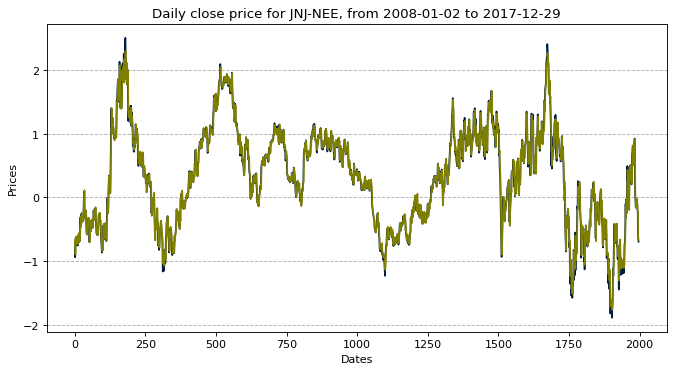

In [125]:
fig = figure(figsize=(10,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 

plt.plot(pair_y_train, label='Actual Train Data', color="#001f3f")
plt.plot(predicted_train, label='Predicted Train Data', color="olive") 

 
display_date_range = "from "+str(x_train.index.min().date())+" to "+str(x_train.index.max().date())

plt.xlabel('Dates') 
plt.ylabel('Prices') 
plt.title("Daily close price for JNJ-NEE"+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()    

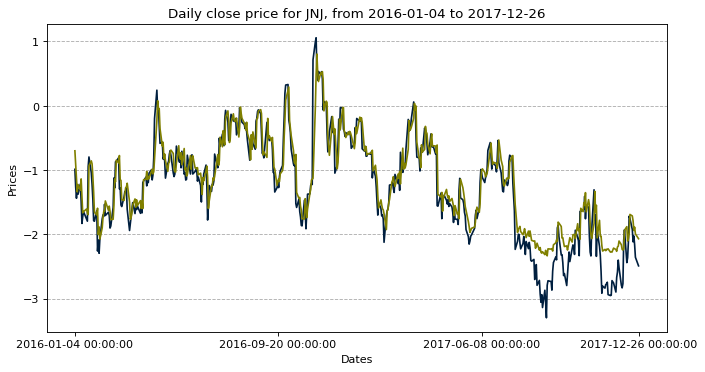

In [126]:
fig = figure(figsize=(10,5), dpi=80) 
fig.patch.set_facecolor((1.0,1.0,1.0)) 

plt.plot(x_test.index, pair_y_val, label='Actual Test Data', color="#001f3f")
plt.plot(x_test.index, predicted_val, label='Predicted Test Data', color="olive") 

xticks = (x_test.index[i] if ((i%180==0) or i==len(x_test.index)-1) else None for i in range(len(x_test.index))) 
 
display_date_range = "from "+str(x_test.index.min().date())+" to "+str(x_test.index.max().date())


xlticks = list(xticks)
x = np.arange(0,len(xlticks)) 
plt.xticks(ticks=xlticks, labels=[date for date in xlticks], ha='center')
 
plt.xlabel('Dates') 
plt.ylabel('Prices') 
plt.title("Daily close price for JNJ"+", "+display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()   